In [ ]:
# 라이브러리 불러오기 
import pandas as pd 
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier # kNN 분류기

# 경고 무시
import warnings
warnings.simplefilter('ignore')
# Unicode warning 제거 (폰트관련 경고 메세지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"



## 01. 이상 데이터 분석 및 처리

In [2]:
# 데이터 불러오기
user_data = pd.read_csv('/Users/kwonkyoungmi/workspaces/workspace_Python/data/user_data.csv')

# 데이터의 상위 5번째 행까지 출력
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,17715,1,384,200,326.4,326.4,1,0.0,1,0,0.0
1,18174,1,50,7,104.0,104.0,1,0.0,1,0,0.0
2,17925,1,72,372,244.1,244.1,1,0.0,1,0,0.0
3,16737,1,288,53,417.6,417.6,1,0.0,1,0,0.0
4,17382,1,24,65,50.4,50.4,1,0.0,1,0,0.0


In [3]:
# 평균, 표준편차, 최솟값, 최댓값 확인

user_data.describe()
user_data.describe().loc[['mean', 'std', 'min', 'max']]


,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
mean,15300.241403,91.603164,1117.375287,91.707703,1894.605181,32.892595,61.169188,3.348764,91.603164,1.949794,2.927453
std,1721.771258,228.297181,4669.107687,100.972922,8266.047438,180.930242,85.366739,11.328177,228.297181,7.171468,9.873250
min,12346.000000,1.000000,-303.000000,0.000000,-1192.200000,-238.400000,1.000000,0.000000,1.000000,0.000000,0.000000
max,18287.000000,7800.000000,196556.000000,373.000000,278778.000000,9904.900000,1791.000000,309.000000,7800.000000,222.000000,100.000000


In [4]:
# Z-score 계산 
z_scores = stats.zscore(user_data.iloc[:, 1:], axis=0)  

# Z-score 절대값 계산
z_scores = np.abs(z_scores)

# Z-score 출력
z_scores

array([[ 0.39691051,  0.1570877 ,  1.07261145, ...,  0.39691051,
         0.27191327,  0.29653746],
       [ 0.39691051,  0.22862991,  0.83901122, ...,  0.39691051,
         0.27191327,  0.29653746],
       [ 0.39691051,  0.22391755,  2.77623373, ...,  0.39691051,
         0.27191327,  0.29653746],
       ...,
       [10.45422645,  7.83015045,  0.90834469, ..., 10.45422645,
        15.34732197,  0.16131765],
       [33.76861921,  4.60432497,  0.8984399 , ..., 33.76861921,
        18.27592858,  0.12332236],
       [25.03338825, 16.21601152,  0.8984399 , ..., 25.03338825,
        30.6876423 ,  0.09041089]])

In [5]:
# 임계값(threshold) 설정
threshold = 3

# z-score 기준으로 이상치를 찾아서 outlier 컬럼에 이상치 여부 기입 (0: 정상, 1:이상치)
user_data['outlier'] = (z_scores > threshold).any(axis=1).astype(int)
'''
`.any(axis=1)` 함수는 는 각 행(axis = 1)에 대해 True가 하나라도 있으면 True를 반환, 그렇지 않으면 False를 반환
'''

user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,outlier
0,17715,1,384,200,326.4,326.4,1,0.0,1,0,0.0,0
1,18174,1,50,7,104.0,104.0,1,0.0,1,0,0.0,0
2,17925,1,72,372,244.1,244.1,1,0.0,1,0,0.0,0
3,16737,1,288,53,417.6,417.6,1,0.0,1,0,0.0,0
4,17382,1,24,65,50.4,50.4,1,0.0,1,0,0.0,0


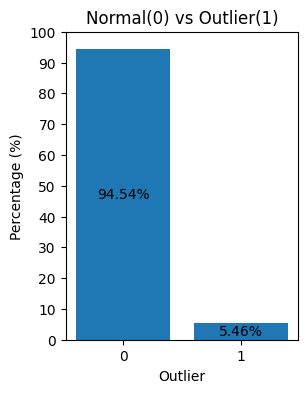

In [6]:
# user_data['outlier']을 활용하여 이상치 여부에 따른 확률 계산
# value_counts()는 열의 고윳값의 개수를 반환하지만 normalize=True를 사용하면 열에 있는 값의 개수 비율(상대적 빈도 0 ~ 1 범위)을 반환함 
outlier_percentage = pd.value_counts(user_data['outlier'], normalize=True) * 100

# 시각화 자료 크기 조정
plt.figure(figsize=(3, 4))

# outlier_percentage라는 데이터로 bar chart 시각화
# x축 값을 0과 1로 지정
bars = plt.bar(['0', '1'], outlier_percentage)

# 퍼센트(%) 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.2f}%', fontsize=10, va='center', ha='center')

plt.title('Normal(0) vs Outlier(1)') # 표 제목
plt.yticks(ticks=np.arange(0, 101, 10)) # y축 표기 (0~100까지 10단위로 증가)
plt.ylabel('Percentage (%)') # y축 범례
plt.xlabel('Outlier') # x축 범례
plt.show() # 출력

In [7]:
# 정상 데이터만 필터링 
user_data = user_data[user_data['outlier'] == 0] 

# outlier 컬럼 삭제 
user_data = user_data.drop(columns=['outlier'])

# DataFrame의 인덱스를 리셋하고, 이전 인덱스를 컬럼으로 추가하지 않음
user_data.reset_index(inplace=True, drop=True)
'''
inplace=True:
    inplace=True를 설정하면 원본 데이터프레임(user_data)이 직접 수정
    inplace=False(기본값)일 경우, 수정된 데이터프레임을 반환하지만 원본은 변경되지 않음
'''
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,17715,1,384,200,326.4,326.4,1,0.0,1,0,0.0
1,18174,1,50,7,104.0,104.0,1,0.0,1,0,0.0
2,17925,1,72,372,244.1,244.1,1,0.0,1,0,0.0
3,16737,1,288,53,417.6,417.6,1,0.0,1,0,0.0
4,17382,1,24,65,50.4,50.4,1,0.0,1,0,0.0


## 02.변수 간 상관관계분석

다중공선성 (MultiCollinearity)
> 회귀분석에서 사용된 모형의 일부 예측 변수가 ~~다른 예측 변수와 상관 정도가 높아~~, 데이터 분석 시 부정적인 영향을 미치는 현상     
여러 개의 변수들이 서로 영향을 주고 있다면, 하나의 영향력을 검증 할 때, 다른 하나의 영향력을 완벽히 통제할 수 없음      
>> - 각 변수의 영향력을 분리해서 추정하기 어려워짐 
>> - 작은 데이터의 변화에도 모델의 변수 예측값이 크게 달리질 수 있음
>> -  실제로 유의미한 결과를 도출하기 어려우며, 해석하기도 어려움       

> 다중공선성 문제 해결 방법 : 문제가 있는 변수를 찾아서
>> - 하나만 선택
>> - 두 변수를 결합하여 새로운 변수 생성 (차원축소기술)


회귀분석
> 독립 변수와 종속 변수 사이의 상관관계를 나타내는 것

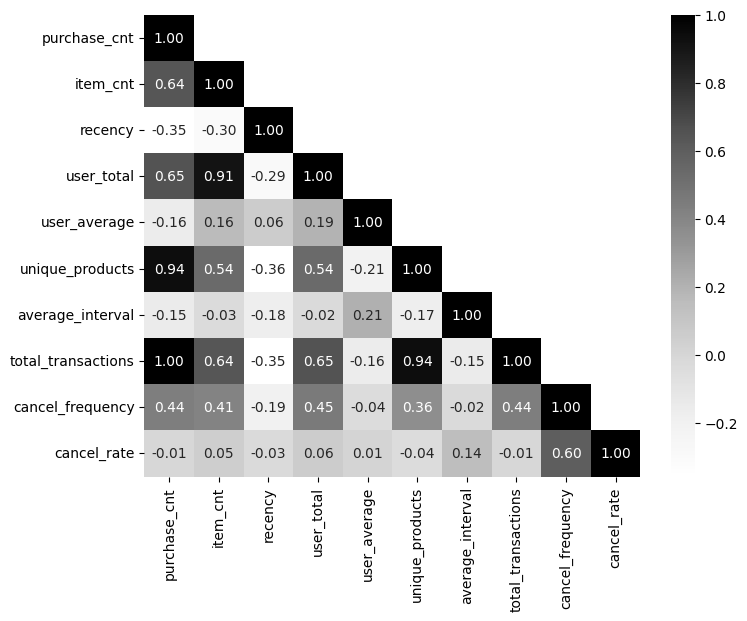

In [8]:
'''상관계수를 시각화 하여 다중공선성 문제 여부 확인'''

# 'CustomerID' 열을 제외(drop)하고 상관 관계 행렬 계산(corr())
corr = user_data.drop(columns=['CustomerID']).corr()

# 행렬이 대각선을 기준으로 대칭이기 때문에 하단만 표시하기 위한 마스크 생성
mask = np.zeros_like(corr) # np.zeros_like()는 0으로 가득찬 array 생성, 크기는 corr와 동일   
mask[np.triu_indices_from(mask, k=1)] = True # array의 대각선 영역과 그 윗 부분에 True가 들어가도록 설정

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, cmap='Greys', annot=True, fmt='.2f')
plt.show()

### 다중공선성 문제 처리 방법
->  차원축소

> steps : feature scalering  -> Dimensionality Reduction

## 03. feature 스케일링

피쳐 스케일링 :  독립변수나 특징들의 ~~범위~~를 정규화

> 종류 (연속형 데이터)
> - standard scaler : 평균 0, 분산 1
> - min max scaler : 최소값 0, 최대값 1
> - Robust scaler : 중앙값과 사분위수를 사용하여 변환
> - Normalizer : 샘플의 벡터 크기가 1이 되도록

In [9]:
# standard scaler 객체 생성
scaler = StandardScaler()

In [10]:
# 원본 데이터에 영향을 주지 않기 위해 복사 
data = user_data.copy()

# CustomerID를 제외한 데이터에 스케일링 적용
columns_list = data.iloc[:, 1:].columns # iloc: 데이터 특정 값 추출, columns: 데이터프레임의 열 이름 조회 
data[columns_list] = scaler.fit_transform(data[columns_list])

'''
scaler.fit_transform() 함수 : fit_transform() 함수는 fit()과 transform()을 연속적으로 수행하는 편리한 방법
                             fit_transform()을 사용하면 원본 데이터는 변경되지 않고, 스케일링된 데이터가 새로운 변수(data)에 저장됨

    1. fit(): 데이터를 기반으로 스케일링 매개변수(평균, 표준편차 등)를 계산
    2. transform(): 계산된 매개변수를 사용하여 데이터를 변환(스케일링)    
'''
# 스케일링된 데이터 확인
data.head()


,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,17715,-0.810174,-0.328003,1.080361,-0.490602,7.453246,-0.961986,-0.577561,-0.810174,-0.428276,-0.443038
1,18174,-0.810174,-0.614216,-0.852875,-0.604139,1.951578,-0.961986,-0.577561,-0.810174,-0.428276,-0.443038
2,17925,-0.810174,-0.595364,2.803245,-0.532617,5.417332,-0.961986,-0.577561,-0.810174,-0.428276,-0.443038
3,16737,-0.810174,-0.410268,-0.392104,-0.444044,9.709326,-0.961986,-0.577561,-0.810174,-0.428276,-0.443038
4,17382,-0.810174,-0.636496,-0.271903,-0.631503,0.625637,-0.961986,-0.577561,-0.810174,-0.428276,-0.443038


## 04. 차원축소

차원 축소 :  다차원 데이터의 차원을 축소하여 새로운 차원이 데이터 생성

> 차원축소의 필요성
> - 다중공선성 식별
> - 노이즈 감소
> - 시각화 향상
> - 계산 효율성 향상

> 차원 축소의 종류 :  PCA, ICA, ISOMAP, t-SNE, UMAP

PCA (principal component analysis) 주성분분석  
> 고차원 데이터의 주요 특징들은 유지하면서 차원을 줄이는 기술   
> 데이터의 feature 수를 줄이면서도 정보를 최대한 보존하는 방식으로 압축     
> 주성분들은 원본데이터의 분산을 최대한 포착-         
- 특징 1) 데이터 내의 선형관계를 잘 포찰       2) 다중공선성이 있는 데이터셋에 효율적

엘보우 포인트 : 누적 설명 분산이 크게 증가하지 않는 지점





In [11]:
# CustomerID를 인덱스로 지정  
data.set_index('CustomerID', inplace=True)

# PCA 적용
pca = PCA().fit(data)

In [12]:
# Explained Variance의 누적합 계산  
explained_variance_ratio = pca.explained_variance_ratio_ # explained_variance_ratio_: Explained Variance 비율을 계산해 주는 함수
cumulative_explained_variance = np.cumsum(explained_variance_ratio) # cumsum: 각 원소의 누적합을 계산하는 함수

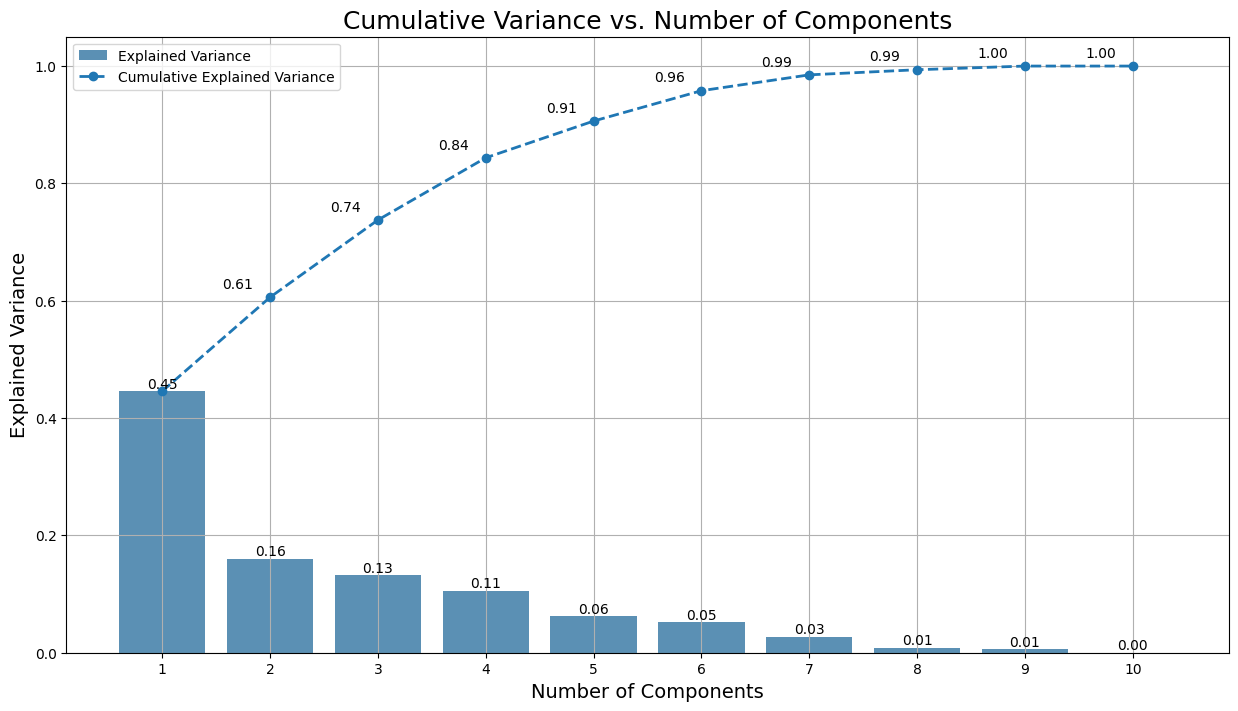

In [13]:
plt.figure(figsize=(15, 8)) 

# 각 성분의 설명된 분포에 대한 막대 그래프
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)), y=explained_variance_ratio, alpha=0.8)

# 누적 분포에 대한 선 그래프
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', linewidth=2)

# 레이블과 제목 설정
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# 눈금 및 범례 사용자 정의
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance', 'Cumulative Explained Variance'])  

# 두 그래프의 분산 값 표시
x_offset = -0.3 # x축 위치 조정
y_offset = 0.01 # y축 위치 조정

# 각 성분의 설명된 분포에 대한 막대 그래프에 값 표시
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

''' 
zip(): 두 개 이상의 iterable 객체를 묶어주는 함수
enumerate(): iterable 객체를 인덱스와 함께 반환하는 함수
i: 인덱스
ev_ratio: 설명된 분포(각 주성분이 데이터의 분산을 얼마나 설명하는지)
cum_ev_ratio: 누적 분포 (누적된 분산 설명 비율)
'''

plt.grid(axis='both')   
plt.show()

In [14]:
# 6개의 주성분을 유지하는 PCA 선언 
pca = PCA(n_components=6)

# 기존 data를 pca에 fit_transform
data_pca = pca.fit_transform(data)

# 압축된 데이터 셋 생성
data_pca = pd.DataFrame(data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# 인덱스로 빼 두었던 CustomerID 다시 추가
data_pca.index = data.index

In [15]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
17715,-2.056335,2.526757,4.366491,3.114148,0.051275,4.511948
18174,-1.592061,0.443320,1.245962,0.173797,-1.285609,1.472905
17925,-2.470006,1.566864,2.941112,3.614607,1.232439,2.972921
16737,-1.836602,3.503738,5.797649,2.775546,-0.903634,6.296835
17382,-1.687145,-0.122366,0.410849,0.169956,-0.906111,0.511552


### PCA

주성분 분석 (PCA, Principal Component Analysis)

주성분 분석(PCA)은 **고차원 데이터의 분산을 최대한 보존하면서 더 낮은 차원의 새로운 변수(주성분, Principal Components)를 찾아내는 차원 축소(dimensionality reduction) 기법**입니다. 복잡하고 많은 변수로 이루어진 데이터를 이해하기 쉽고 시각화하기 용이한 저차원 데이터로 변환하는 데 널리 사용됩니다.

**PCA의 핵심 아이디어:**

* **분산 최대화:** 데이터의 분산이 크다는 것은 정보의 손실이 적다는 의미입니다. PCA는 데이터의 분산을 가장 잘 설명하는 방향(주성분)을 순서대로 찾아냅니다.
* **직교성:** 찾아낸 주성분들은 서로 직교(orthogonal, 선형적으로 독립)합니다. 이는 각 주성분이 서로 중복되는 정보를 담고 있지 않다는 것을 의미합니다.

**PCA의 작동 원리:**

1.  **데이터 표준화 (Standardization):** 변수들의 스케일이 다르면 분산에 미치는 영향이 달라지므로, 일반적으로 PCA를 적용하기 전에 데이터를 평균이 0이고 분산이 1이 되도록 표준화합니다.
2.  **공분산 행렬 계산 (Covariance Matrix):** 데이터의 변수들 간의 공분산을 나타내는 행렬을 계산합니다. 공분산은 두 변수가 함께 변하는 정도를 나타냅니다.
3.  **고유값(Eigenvalue)과 고유 벡터(Eigenvector) 계산:** 공분산 행렬의 고유값과 고유 벡터를 계산합니다.
    * **고유 벡터:** 데이터의 분산이 가장 큰 방향을 나타냅니다. PCA에서는 이 고유 벡터들이 주성분이 됩니다.
    * **고유값:** 각 고유 벡터(주성분)가 설명하는 데이터의 분산 크기를 나타냅니다. 고유값이 클수록 해당 주성분이 데이터의 정보를 더 많이 담고 있습니다.
4.  **주성분 선택 및 투영 (Projection):** 고유값을 기준으로 내림차순으로 정렬하고, 분석 목적에 따라 중요한 상위 k개의 주성분을 선택합니다. 원래의 고차원 데이터를 선택된 k개의 주성분 벡터에 투영(project)하여 k차원의 새로운 데이터셋을 얻습니다.

**PCA의 장점:**

* **차원 축소:** 고차원 데이터를 저차원으로 줄여 데이터 분석 및 모델링의 효율성을 높이고 시각화를 용이하게 합니다.
* **다중 공선성 해결:** 변수들 간의 높은 상관관계(다중 공선성) 문제를 완화하여 모델의 안정성을 높일 수 있습니다.
* **노이즈 감소:** 분산이 작은 주성분은 노이즈 성분을 많이 포함할 가능성이 있으므로, 이를 제거하여 데이터의 신호(signal)를 강조할 수 있습니다.
* **정보 손실 최소화:** 분산이 큰 주성분을 우선적으로 선택하므로, 데이터의 중요한 정보 손실을 최소화하면서 차원을 축소할 수 있습니다.

**PCA의 단점:**

* **해석의 어려움:** 새롭게 생성된 주성분들은 원래 변수들의 선형 결합으로 이루어지기 때문에, 각 주성분이 구체적으로 어떤 의미를 가지는지 해석하기 어려울 수 있습니다.
* **비선형 관계 포착 불가:** PCA는 선형적인 차원 축소 기법이므로, 데이터에 존재하는 비선형적인 관계는 제대로 포착하지 못할 수 있습니다.
* **스케일링 의존성:** 변수들의 스케일에 민감하게 반응하므로, PCA 적용 전에 적절한 데이터 표준화가 필요합니다.
* **정보 손실 가능성:** 차원을 축소하는 과정에서 불가피하게 일부 정보 손실이 발생할 수 있습니다.

**PCA의 활용 분야:**

* **이미지 압축 및 특징 추출:** 이미지 데이터의 차원을 줄여 저장 공간을 효율적으로 사용하고, 이미지의 주요 특징을 추출하여 패턴 인식 등에 활용됩니다.
* **얼굴 인식:** 고차원 얼굴 이미지 데이터를 저차원의 주성분으로 변환하여 얼굴 특징을 추출하고 인식하는 데 사용됩니다.
* **유전자 데이터 분석:** 수많은 유전자 발현 데이터의 차원을 축소하여 주요 유전자 그룹을 식별하고 질병과의 연관성을 분석하는 데 활용됩니다.
* **금융 데이터 분석:** 주식 가격, 경제 지표 등 고차원 금융 데이터의 차원을 축소하여 투자 전략 개발 및 위험 관리 등에 활용됩니다.
* **추천 시스템:** 사용자-아이템 상호작용 데이터의 차원을 축소하여 사용자 및 아이템의 잠재 요인을 발견하고 추천 성능을 향상시키는 데 사용됩니다.




> PCA(주성분 분석)에서 **분산이 크다는 것이 정보의 손실이 적다는 의미**인 이유는 다음과 같이 설명할 수 있습니다.

> **1. 분산은 데이터의 '퍼짐 정도'를 나타냅니다.**
> * 분산이 크다는 것은 데이터 값들이 평균으로부터 멀리 떨어져 넓게 퍼져 있다는 의미입니다.
>* 이는 데이터 안에 다양한 변화와 개별적인 특성이 많이 존재한다는 것을 시사합니다.

> **2. 정보는 '차이'와 '변화'에서 비롯됩니다.**
> * 만약 모든 데이터 포인트가 동일한 값을 가진다면 (분산이 0), 그 데이터셋에는 아무런 정보가 없다고 볼 수 있습니다. 예측이나 분류 등 어떤 분석을 하더라도 의미 있는 결과를 얻을 수 없기 때문입니다.
>* 데이터에 차이가 많고 변화가 클수록, 그 데이터를 통해 더 많은 것을 학습하고 이해할 수 있는 잠재력이 커집니다. 즉, 정보량이 많다고 해석할 수 있습니다.

>**3. PCA는 분산을 최대한 보존하는 새로운 축을 찾습니다.**
>* PCA의 핵심 목표는 고차원 데이터를 저차원으로 축소하되, 원래 데이터의 **분산을 최대한 많이 유지**하는 새로운 주성분(축)을 찾는 것입니다.
>* 분산을 많이 유지한다는 것은 데이터의 중요한 '차이'와 '변화'를 새로운 저차원 공간에서도 가능한 한 많이 보존한다는 의미입니다.

>**4. 분산을 적게 유지하는 것은 정보 손실을 의미합니다.**
>* 만약 PCA가 분산이 작은 방향으로 데이터를 투영한다면, 원래 데이터에 존재하던 중요한 변화나 특성들이 압축 과정에서 사라지게 됩니다. 이는 정보의 손실로 이어집니다.
>* 극단적인 예로, 분산이 거의 없는 방향으로 투영하면 모든 데이터 포인트가 거의 동일한 값으로 표현되어 원래 데이터의 다양성을 잃게 됩니다.

>**비유를 들어보면:**
>* **분산이 큰 데이터:** 여러 가지 색깔과 다양한 무늬가 있는 천 조각
>* **분산이 작은 데이터:** 거의 단색이고 무늬가 거의 없는 천 조각

>PCA를 통해 이 천 조각을 더 작은 크기로 잘라낸다고 생각해 봅시다.

>* **분산이 큰 천 조각**에서 원래의 다양한 색깔과 무늬를 가능한 한 많이 유지하면서 자르는 것이 정보 손실을 최소화하는 방법입니다.
>* **분산이 작은 천 조각**은 이미 정보가 적기 때문에 어떻게 잘라도 잃을 정보가 많지 않겠지만, 중요한 특징 자체가 별로 없습니다.

>따라서 PCA는 데이터의 '다양성'과 '특성'을 나타내는 '분산'을 최대한 보존함으로써 차원 축소 과정에서의 정보 손실을 최소화하려고 노력하는 것입니다. 분산이 크다는 것은 그만큼 데이터에 중요한 정보가 많이 담겨 있을 가능성이 높다는 것을 의미하며, PCA는 이러한 정보를 최대한 유지하는 방향으로 데이터를 압축합니다.

설명된 분산 비율: [0.26386183 0.22838409 0.19433259 0.16565351 0.14776798]


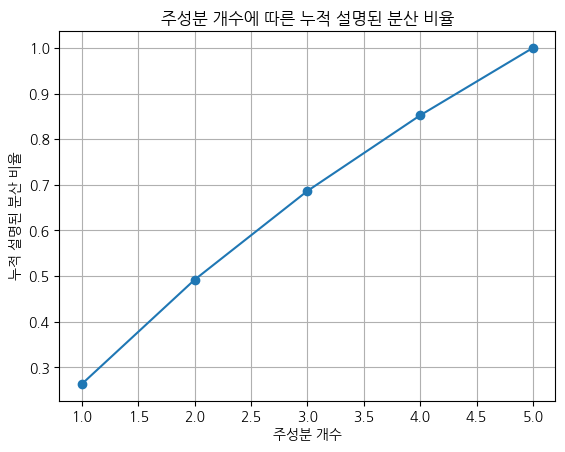


원본 데이터 형태: (100, 5)
2개의 주성분으로 축소된 데이터 형태: (100, 2)


In [ ]:
# 예시
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Unicode warning 제거 (폰트관련 경고 메세지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"


# 예시 데이터 생성
np.random.seed(0)
X = np.random.rand(100, 5)

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 모델 생성 및 학습
pca = PCA()
pca.fit(X_scaled)

# 설명된 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
print("설명된 분산 비율:", explained_variance_ratio)

# 누적 설명된 분산 비율 시각화
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명된 분산 비율')
plt.title('주성분 개수에 따른 누적 설명된 분산 비율')
plt.grid(True)
plt.show()

# 원하는 주성분 개수로 차원 축소
n_components = 2
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)

print("\n원본 데이터 형태:", X_scaled.shape)
print(f"{n_components}개의 주성분으로 축소된 데이터 형태:", X_reduced.shape)

## 05. K-means Clustering

지정된 그룹 수(K)로 데이터를 클러스터링하는 비지도 학습 알고리즘        
각 군집의 평균을 확용하여 K개 군집(cluster)으로 묶는 방식       
각 데이터 포인트를 가장 가까운 중심으로 할당한 다음 모든 할당된 포인트의 평균을 계산하여 중심을 업데이트        
> (주의) 실행 할 때 마다 클러스터에 다른 레이블 할당 => 각 클러스터의 샘플빈도를 기반으로 레이블을 교환하는 추가 단계 수행 for 일관된 레이블 할당



In [16]:
# k=3개의 클러스터로 K-Means 클러스터링 적용
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(data_pca)    

'''
n_clusters=3: 클러스터의 개수를 3으로 설정
init='k-means++': 초기 클러스터 중심을 효율적으로 선택하는 방법을 사용
n_init=10: K-Means 알고리즘을 10번 실행하여 최적의 결과를 선택
max_iter=100: 최대 반복 횟수를 100
random_state=0: 결과 재현성을 위해 난수 시드를 고정
'''

# 각 클러스터의 빈도수 구하기
cluster_frequencies = Counter(kmeans.labels_) 

# 빈도수에 기반하여 이전 레이블에서 새 레이블로의 매핑 생성
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

'''
`.most_common(n)`
Python의 collections.Counter 클래스에서 제공하는 메서드로, 요소의 빈도수를 기준으로 내림차순 정렬된 리스트를 반환
n을 지정하지 않으면 모든 요소를 반환

`for new_label, (label, _) in enumerate(...)`
new_label: 새로 매핑될 레이블(0, 1, 2, ...).
(label, _): 기존 클러스터 레이블(label)과 해당 빈도수(_)를 언패킹합니다. 빈도수는 사용하지 않으므로 _로 처리합니다.
'''

# 매핑을 적용하여 새 레이블 얻기
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# 원래 데이터셋에 새 클러스터 레이블 추가
user_data['cluster'] = new_labels

# PCA 버전의 데이터셋에 새 클러스터 레이블 추가
data_pca['cluster'] = new_labels

In [17]:
# K-Means 분류된 결과 보기
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate,cluster
0,17715,1,384,200,326.4,326.4,1,0.0,1,0,0.0,0
1,18174,1,50,7,104.0,104.0,1,0.0,1,0,0.0,0
2,17925,1,72,372,244.1,244.1,1,0.0,1,0,0.0,0
3,16737,1,288,53,417.6,417.6,1,0.0,1,0,0.0,0
4,17382,1,24,65,50.4,50.4,1,0.0,1,0,0.0,0


In [18]:
# 각 군집별로 몇 명의 고객이 있는지 확인
user_data.value_counts('cluster')

cluster
0    3033
1     583
2     508
Name: count, dtype: int64

## 06. 시각화 및 결과 분석

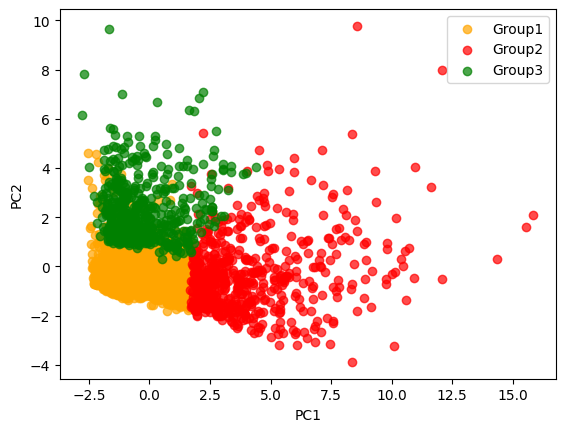

In [19]:
# 각 클러스터 별 데이터 분리 
cluster_0 = data_pca[data_pca['cluster'] == 0]
cluster_1 = data_pca[data_pca['cluster'] == 1]
cluster_2 = data_pca[data_pca['cluster'] == 2]


# 클러스터 별 시각화
plt.scatter(cluster_0['PC1'], cluster_0['PC2'], color = 'orange', alpha = 0.7, label = 'Group1')
plt.scatter(cluster_1['PC1'], cluster_1['PC2'], color = 'red', alpha = 0.7, label = 'Group2')
plt.scatter(cluster_2['PC1'], cluster_2['PC2'], color = 'green', alpha = 0.7, label = 'Group3')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [20]:
# 색상 지정 
colors = ['red', 'blue', 'green']

# 각 클러스터별 데이터 분릴
cluster_0 = data_pca[data_pca['cluster'] == 0]
cluster_1 = data_pca[data_pca['cluster'] == 1]
cluster_2 = data_pca[data_pca['cluster'] == 2]

# 3D 시각화
fig = go.Figure()

# 각 클러스터별 데이터 표기 
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Group 1'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Group 2'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Group 3'))

# 범례 및 제목 영역 설정
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

### code 탐색

In [21]:
'''
n_clusters=3: 클러스터의 개수를 3으로 설정
init='k-means++': 초기 클러스터 중심을 효율적으로 선택하는 방법을 사용
n_init=10: K-Means 알고리즘을 10번 실행하여 최적의 결과를 선택
max_iter=100: 최대 반복 횟수를 100
random_state=0: 결과 재현성을 위해 난수 시드를 고정
'''

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(data_pca)    


KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=0)

In [22]:
kmeans.labels_


array([0, 0, 0, ..., 1, 2, 2], dtype=int32)

In [23]:
Counter(kmeans.labels_)

Counter({0: 3033, 1: 583, 2: 508})

In [24]:
cluster_frequencies = Counter(kmeans.labels_) 
type(cluster_frequencies)

collections.Counter

In [25]:
# 빈도수에 기반하여 이전 레이블에서 새 레이블로의 매핑 생성
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

label_mapping

{0: 0, 1: 1, 2: 2}

In [26]:
# 매핑을 적용하여 새 레이블 얻기
np.array([label_mapping[label] for label in kmeans.labels_])

# for label in kmeans.labels_:
#     print(label_mapping[label], end=' ')


array([0, 0, 0, ..., 1, 2, 2])

## 추가) KNN

k-nearest neighbors, k-최근접 이웃      
- 별도의 훈련시간이 필요하지 않음

In [27]:
# kNN 분류기 모델 생성
knn_cls = KNeighborsClassifier()